### Visualizing the classification manifold of NONA VS LR VS KNN on differently arranged synthetic data

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.neural_network import MLPClassifier, MLPRegressor
import models as nona
import similarity_masks as masks
import torch
import torch.optim as optim
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from mpl_toolkits import mplot3d
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor

from importlib import reload

Linearly separable data

In [ ]:
np.random.seed(42)

num_samples = 500
X = np.random.uniform(-1,1, (num_samples,2))

m = 0 
b = 0.0 

noise = np.random.normal(0, 0.1, num_samples)
y = (X[:, 1] > (m * X[:, 0] + b + noise)).astype(int)

X = torch.tensor(X, dtype=torch.float64)
y = torch.tensor(y, dtype=torch.float64)

plt.figure(figsize=(6, 6))
plt.scatter(X[:, 0], X[:, 1], c=y, cmap='bwr', edgecolors='k', alpha=0.75)
x_vals = np.linspace(-1, 1, 100)
# plt.plot(x_vals, m * x_vals + b, 'k--', label="Decision boundary")
plt.xlim(-1, 1)
plt.ylim(-1, 1)
plt.show()

print('Class distribution:', np.unique(y, return_counts=True))

Alt: clustered linearly separable data

In [ ]:
np.random.seed(42)

num_samples = 500
X_00 = np.random.uniform(-1,-0.5, size=(num_samples,))
X_01 = np.random.uniform(-0.25, 0.25, size=(num_samples,))
X_10 = np.random.uniform(0.5, 1, size=(num_samples,))
X_11 = np.random.uniform(-0.25, 0.25, size=(num_samples,))

X_0 = np.stack([X_00, X_01]).T
X_1 = np.stack([X_10, X_11]).T


X = np.concatenate([X_0, X_1])


y_0 = np.zeros(num_samples)
y_1 = np.ones(num_samples)

y = np.concatenate([y_0,y_1])

X = torch.tensor(X, dtype=torch.float64)
y = torch.tensor(y, dtype=torch.float64)

plt.figure(figsize=(6, 6))
plt.scatter(X[:, 0], X[:, 1], c=y, cmap='bwr', edgecolors='k', alpha=0.75)
x_vals = np.linspace(0, 1, 100)
# plt.plot(x_vals, m * x_vals + b, 'k--', label="Decision boundary")
plt.xlim(-1, 1)
plt.ylim(-1, 1)
plt.show()

In [ ]:
model = LogisticRegression()
model.fit(X, y)

# Create a grid over [0,1]^2 for visualization
grid_size = 100
axes = 1
xx, yy = np.meshgrid(np.linspace(-axes, axes, grid_size), np.linspace(-axes, axes, grid_size))
grid_points = torch.tensor(np.c_[xx.ravel(), yy.ravel()], dtype=torch.float64)
probabilities = model.predict_proba(grid_points)[:, 1].reshape(grid_size, grid_size)

# Plot the heatmap using contourf
plt.figure(figsize=(8, 6))
plt.contourf(xx, yy, probabilities, levels=20, cmap="coolwarm", alpha=0.75)

# Scatter plot of data points
# plt.scatter(X[y == 0, 0], X[y == 0, 1], color="blue", label="Class 0", alpha=0.6, edgecolor='k')
# plt.scatter(X[y == 1, 0], X[y == 1, 1], color="red", label="Class 1", alpha=0.6, edgecolor='k')

plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.title("Logistic Regression Probability Heatmap")
plt.colorbar(label="Probability of Class 1")
plt.show()

In [ ]:
model = KNeighborsClassifier()
model.fit(X,y)
probabilities = model.predict_proba(grid_points)[:, 1].reshape(grid_size, grid_size)

# Plot the heatmap using contourf
plt.figure(figsize=(8, 8))
plt.contourf(xx, yy, probabilities, levels=20, cmap="coolwarm", alpha=0.75)

# Scatter plot of data points
# plt.scatter(X[y == 0, 0], X[y == 0, 1], color="blue", label="Class 0", alpha=0.6, edgecolor='k')
# plt.scatter(X[y == 1, 0], X[y == 1, 1], color="red", label="Class 1", alpha=0.6, edgecolor='k')

plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.title("KNN Probability Heatmap")
plt.colorbar(label="Probability of Class 1")
plt.show()

In [ ]:
model = nona.NONA()
probabilities = model(grid_points, X, y).reshape(grid_size, grid_size)

# Plot the heatmap using contourf
plt.figure(figsize=(8, 6))
plt.contourf(xx, yy, probabilities, levels=20, cmap="coolwarm", alpha=0.75)

# Scatter plot of data points
# plt.scatter(X[y == 0, 0], X[y == 0, 1], color="blue", label="Class 0", alpha=0.6, edgecolor='k')
# plt.scatter(X[y == 1, 0], X[y == 1, 1], color="red", label="Class 1", alpha=0.6, edgecolor='k')

plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.title("NONA Euclidean Probability Heatmap")
plt.colorbar(label="Probability of Class 1")
plt.show()

In [ ]:
x_grid = torch.linspace(-2, 2, 100).to(torch.float64)
y_grid = torch.linspace(-2, 2, 100).to(torch.float64)

grid = torch.cartesian_prod(x_grid, y_grid)

Z = model(grid, X, y).reshape(100,100).detach()

X_grid, Y_grid = np.meshgrid(x_grid, y_grid)

fig = plt.figure()
ax = plt.axes(projection ='3d')
ax.plot_wireframe(X_grid, Y_grid, Z, color ='green')

In [ ]:
model = nona.NONA(similarity='dot')
probabilities = model(grid_points, X, y).reshape(grid_size, grid_size)

# Plot the heatmap using contourf
plt.figure(figsize=(8, 6))
plt.contourf(xx, yy, probabilities, levels=20, cmap="coolwarm", alpha=0.75)

# Scatter plot of data points
# plt.scatter(X[y == 0, 0], X[y == 0, 1], color="blue", label="Class 0", alpha=0.6, edgecolor='k')
# plt.scatter(X[y == 1, 0], X[y == 1, 1], color="red", label="Class 1", alpha=0.6, edgecolor='k')

plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.title("NONA Dot Product Similarity Probability Heatmap")
plt.colorbar(label="Probability of Class 1")
plt.show()

In [ ]:
x_grid = torch.linspace(-2, 2, 100).to(torch.float64)
y_grid = torch.linspace(-2, 2, 100).to(torch.float64)

grid = torch.cartesian_prod(x_grid, y_grid)

Z = model(grid, X, y).reshape(100,100).detach()

X_grid, Y_grid = np.meshgrid(x_grid, y_grid)

fig = plt.figure()
ax = plt.axes(projection ='3d')
ax.plot_wireframe(X_grid, Y_grid, Z, color ='green')

Radially separable data

In [ ]:
np.random.seed(42)

n_samples = 1000
X = np.random.uniform(-1,1, size=(n_samples, 2))

# Define radial boundary
center = np.array([0, 0])
radius = 0.8 

distances = np.linalg.norm(X - center, axis=1)

# Assign labels based on radial distance, adding noise
y = (distances + 0.05 * np.random.randn(n_samples) > radius).astype(int)

X = torch.tensor(X, dtype=torch.float64)
y = torch.tensor(y, dtype=torch.float64)


# Plot the data
plt.figure(figsize=(8, 8))
plt.scatter(X[y == 0, 0], X[y == 0, 1], color="blue", label="Inside (Class 0)", alpha=0.6, edgecolor='k')
plt.scatter(X[y == 1, 0], X[y == 1, 1], color="red", label="Outside (Class 1)", alpha=0.6, edgecolor='k')

# Plot the true decision boundary
circle = plt.Circle(center, radius, color="black", linestyle="dashed", fill=False, label="Decision Boundary")
plt.gca().add_patch(circle)

plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.title("Radially Separable Binary Classification Data")
plt.legend()
plt.xlim(-1, 1)
plt.ylim(-1, 1)
plt.show()

print("Class distribution", np.unique(y, return_counts=True))

In [ ]:
model = LogisticRegression()
model.fit(X, y)

# Create a grid over [0,1]^2 for visualization
grid_size = 100
xx, yy = np.meshgrid(np.linspace(-10, 10, grid_size), np.linspace(-10, 10, grid_size))
grid_points = torch.tensor(np.c_[xx.ravel(), yy.ravel()], dtype=torch.float64)
probabilities = model.predict_proba(grid_points)[:, 1].reshape(grid_size, grid_size)

# Plot the heatmap using contourf
plt.figure(figsize=(8, 6))
plt.contourf(xx, yy, probabilities, levels=20, cmap="coolwarm", alpha=0.75)

# Scatter plot of data points
# plt.scatter(X[y == 0, 0], X[y == 0, 1], color="blue", label="Class 0", alpha=0.6, edgecolor='k')
# plt.scatter(X[y == 1, 0], X[y == 1, 1], color="red", label="Class 1", alpha=0.6, edgecolor='k')

plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.title("Logistic Regression Probability Heatmap")
plt.colorbar(label="Probability of Class 1")
plt.show()

In [ ]:
model = KNeighborsClassifier()
model.fit(X,y)
probabilities = model.predict_proba(grid_points)[:, 1].reshape(grid_size, grid_size)

# Plot the heatmap using contourf
plt.figure(figsize=(8, 8))
plt.contourf(xx, yy, probabilities, levels=20, cmap="coolwarm", alpha=0.75)

# Scatter plot of data points
# plt.scatter(X[y == 0, 0], X[y == 0, 1], color="blue", label="Class 0", alpha=0.6, edgecolor='k')
# plt.scatter(X[y == 1, 0], X[y == 1, 1], color="red", label="Class 1", alpha=0.6, edgecolor='k')

plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.title("KNN Probability Heatmap")
plt.colorbar(label="Probability of Class 1")
plt.show()

In [ ]:
model = nona.NONA()
probabilities = model(grid_points, X, y).reshape(grid_size, grid_size)

# Plot the heatmap using contourf
plt.figure(figsize=(8, 6))
plt.contourf(xx, yy, probabilities, levels=20, cmap="coolwarm", alpha=0.75)

# Scatter plot of data points
# plt.scatter(X[y == 0, 0], X[y == 0, 1], color="blue", label="Class 0", alpha=0.6, edgecolor='k')
# plt.scatter(X[y == 1, 0], X[y == 1, 1], color="red", label="Class 1", alpha=0.6, edgecolor='k')

plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.title("NONA Euclidean Probability Heatmap")
plt.colorbar(label="Probability of Class 1")
plt.show()

In [ ]:
# x and y axis
x_grid = torch.linspace(-2, 2, 100).to(torch.float64)
y_grid = torch.linspace(-2, 2, 100).to(torch.float64)

X_test = torch.cartesian_prod(x_grid, y_grid)

Z = model(X_test, X, y).reshape(100,100).detach()

X_grid, Y_grid = np.meshgrid(x_grid, y_grid)

fig = plt.figure()
ax = plt.axes(projection ='3d')
ax.plot_wireframe(X_grid, Y_grid, Z, color ='green')

In [ ]:
model = nona.NONA(similarity='dot')
probabilities = model(grid_points, X, y).reshape(grid_size, grid_size).cpu().detach()

# Plot the heatmap using contourf
plt.figure(figsize=(8, 6))
plt.contourf(xx, yy, probabilities, levels=20, cmap="coolwarm", alpha=0.75)

# Scatter plot of data points
# plt.scatter(X[y == 0, 0], X[y == 0, 1], color="blue", label="Class 0", alpha=0.6, edgecolor='k')
# plt.scatter(X[y == 1, 0], X[y == 1, 1], color="red", label="Class 1", alpha=0.6, edgecolor='k')

plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.title("NONA Dot Product Similarity Probability Heatmap")
plt.colorbar(label="Probability of Class 1")
plt.show()

In [ ]:
# x and y axis
x_grid = torch.linspace(-2, 2, 100).to(torch.float64)
y_grid = torch.linspace(-2, 2, 100).to(torch.float64)

X_test = torch.cartesian_prod(x_grid, y_grid)

Z = model(X_test, X, y).reshape(100,100).detach()

X_grid, Y_grid = np.meshgrid(x_grid, y_grid)

fig = plt.figure()
ax = plt.axes(projection ='3d')
ax.plot_wireframe(X_grid, Y_grid, Z, color ='green')

In [ ]:
np.random.seed(42)

# Generate data for two interlocked spirals
n_samples = 500
theta = np.linspace(0, 4 * np.pi, n_samples)
r = np.linspace(0, 1, n_samples)
noise = np.random.normal(0, 0.02, n_samples)

phase_0 = 0
X_0 = np.array([(r + noise) * np.sin(theta + phase_0 + noise), (r + noise) * np.cos(theta + phase_0 + noise)]).T
y_0 = np.zeros(n_samples)

phase_1 = np.pi
X_1 = np.array([(r + noise) * np.sin(theta + phase_1 + noise), (r + noise) * np.cos(theta + phase_1 + noise)]).T
y_1 = np.ones(n_samples)

X = np.concat([X_0, X_1], axis=0)
y = np.concat([y_0, y_1], axis=0)


X = torch.tensor(X, dtype=torch.float64)
y = torch.tensor(y, dtype=torch.float64)

# Plot the data
plt.figure(figsize=(8, 8))
plt.scatter(X_0[:,0], X_0[:,1], color="blue", label="Class 0", alpha=0.6, edgecolor='k')
plt.scatter(X_1[:,0], X_1[:,1], color="red", label="Class 1", alpha=0.6, edgecolor='k')

plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.title("Interlocked Spirals Binary Classification Data")
plt.legend()
plt.show()


In [ ]:
model = LogisticRegression()
model.fit(X, y)

# Create a grid over [0,1]^2 for visualization
grid_size = 100
xx, yy = np.meshgrid(np.linspace(-1, 1, grid_size), np.linspace(-1, 1, grid_size))
grid_points = torch.tensor(np.c_[xx.ravel(), yy.ravel()], dtype=torch.float64)
probabilities = model.predict_proba(grid_points)[:, 1].reshape(grid_size, grid_size)

# Plot the heatmap using contourf
plt.figure(figsize=(8, 6))
plt.contourf(xx, yy, probabilities, levels=20, cmap="coolwarm", alpha=0.75)

# Scatter plot of data points
# plt.scatter(X[y == 0, 0], X[y == 0, 1], color="blue", label="Class 0", alpha=0.6, edgecolor='k')
# plt.scatter(X[y == 1, 0], X[y == 1, 1], color="red", label="Class 1", alpha=0.6, edgecolor='k')

plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.title("Logistic Regression Probability Heatmap")
plt.colorbar(label="Probability of Class 1")
plt.show()

In [ ]:
model = MLPClassifier()
model.fit(X, y)

# Create a grid over [0,1]^2 for visualization
grid_size = 100
xx, yy = np.meshgrid(np.linspace(-1, 1, grid_size), np.linspace(-1, 1, grid_size))
grid_points = torch.tensor(np.c_[xx.ravel(), yy.ravel()], dtype=torch.float64)
probabilities = model.predict_proba(grid_points)[:, 1].reshape(grid_size, grid_size)

# Plot the heatmap using contourf
plt.figure(figsize=(8, 6))
plt.contourf(xx, yy, probabilities, levels=20, cmap="coolwarm", alpha=0.75)

# Scatter plot of data points
# plt.scatter(X[y == 0, 0], X[y == 0, 1], color="blue", label="Class 0", alpha=0.6, edgecolor='k')
# plt.scatter(X[y == 1, 0], X[y == 1, 1], color="red", label="Class 1", alpha=0.6, edgecolor='k')

plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.title("MLP Probability Heatmap")
plt.colorbar(label="Probability of Class 1")
plt.show()

In [ ]:
model = KNeighborsClassifier()
model.fit(X,y)
probabilities = model.predict_proba(grid_points)[:, 1].reshape(grid_size, grid_size)

# Plot the heatmap using contourf
plt.figure(figsize=(8, 8))
plt.contourf(xx, yy, probabilities, levels=20, cmap="coolwarm", alpha=0.75)

# Scatter plot of data points
# plt.scatter(X[y == 0, 0], X[y == 0, 1], color="blue", label="Class 0", alpha=0.6, edgecolor='k')
# plt.scatter(X[y == 1, 0], X[y == 1, 1], color="red", label="Class 1", alpha=0.6, edgecolor='k')

plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.title("KNN Probability Heatmap")
plt.colorbar(label="Probability of Class 1")
plt.show()

In [ ]:
model = nona.NONA()
probabilities = model(grid_points, X, y).reshape(grid_size, grid_size)

# Plot the heatmap using contourf
plt.figure(figsize=(8, 6))
plt.contourf(xx, yy, probabilities, levels=20, cmap="coolwarm", alpha=0.75)

# Scatter plot of data points
# plt.scatter(X[y == 0, 0], X[y == 0, 1], color="blue", label="Class 0", alpha=0.6, edgecolor='k')
# plt.scatter(X[y == 1, 0], X[y == 1, 1], color="red", label="Class 1", alpha=0.6, edgecolor='k')

plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.title("NONA Euclidean Probability Heatmap")
plt.colorbar(label="Probability of Class 1")
plt.show()

In [ ]:
# x and y axis
x_grid = torch.linspace(-2, 2, 100).to(torch.float64)
y_grid = torch.linspace(-2, 2, 100).to(torch.float64)

X_test = torch.cartesian_prod(x_grid, y_grid)

Z = model(X_test, X, y).reshape(100,100).detach()
x_grid = x_grid.detach()
y_grid = y_grid.detach()
X_grid, Y_grid = np.meshgrid(x_grid, y_grid)

fig = plt.figure()
ax = plt.axes(projection ='3d')
ax.plot_wireframe(X_grid, Y_grid, Z, color ='green')

In [ ]:
model = nona.NONA(similarity='dot')
probabilities = model(grid_points, X, y).reshape(grid_size, grid_size).cpu().detach()

# Plot the heatmap using contourf
plt.figure(figsize=(8, 8))
plt.contourf(xx, yy, probabilities, levels=20, cmap="coolwarm", alpha=0.75)

# Scatter plot of data points
# plt.scatter(X[y == 0, 0], X[y == 0, 1], color="blue", label="Class 0", alpha=0.6, edgecolor='k')
# plt.scatter(X[y == 1, 0], X[y == 1, 1], color="red", label="Class 1", alpha=0.6, edgecolor='k')

plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.title("NONA Dot Product Similarity Probability Heatmap")
plt.colorbar(label="Probability of Class 1")
plt.show()

In [ ]:
# x and y axis
x_grid = torch.linspace(-2, 2, 100).to(torch.float64)
y_grid = torch.linspace(-2, 2, 100).to(torch.float64)

X_test = torch.cartesian_prod(x_grid, y_grid)

Z = model(X_test, X, y).reshape(100,100).detach()
x_grid = x_grid.detach()
y_grid = y_grid.detach()
X_grid, Y_grid = np.meshgrid(x_grid, y_grid)

fig = plt.figure()
ax = plt.axes(projection ='3d')
ax.plot_wireframe(X_grid, Y_grid, Z, color ='green')

### Radial data with continuous target

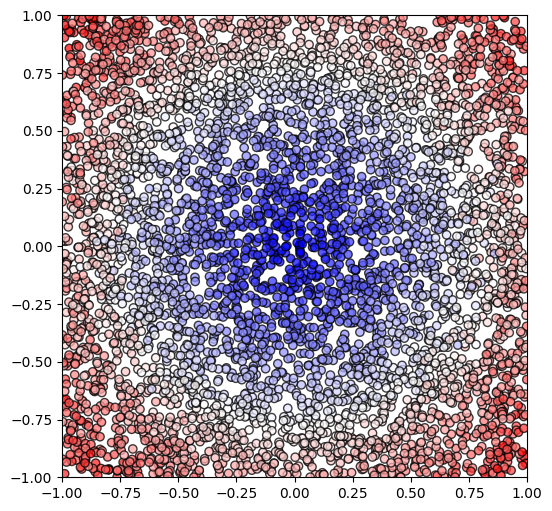

In [37]:
np.random.seed(42)

train_samples = 5000
X_train = np.random.uniform(-1,1, (train_samples,2))
def sample_unit_disk(n):
    r = np.sqrt(np.random.rand(n))  # Square root to ensure uniform distribution
    theta = 2 * np.pi * np.random.rand(n)  # Uniformly distributed angle
    x = r * np.cos(theta)
    y = r * np.sin(theta)
    return np.column_stack((x, y))
# X_train = sample_unit_disk(train_samples) 

noise = np.random.normal(0, 0.1, train_samples)
y_train = np.sqrt(X_train[:,0] ** 2 + X_train[:,1] ** 2) + (noise * X_train[:,0]) #heteroscedasticity
y_train = (y_train - y_train.min()) / (y_train.max() - y_train.min())
X_train = torch.tensor(X_train, dtype=torch.float64)
y_train = torch.tensor(y_train, dtype=torch.float64)



plt.figure(figsize=(6, 6))
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap='bwr', edgecolors='k', alpha=0.75)
x_vals = np.linspace(-1, 1, 100)
plt.xlim(-1, 1)
plt.ylim(-1, 1)
plt.show()

test_samples = 500
X_test = np.random.uniform(-1,1, (test_samples,2))
# X_test = sample_unit_disk(test_samples)
noise = np.random.normal(0, 0.1, test_samples)
y_test = np.sqrt(X_test[:,0] ** 2 + X_test[:,1] ** 2) + (noise * X_test[:,0])
y_test = (y_test - y_test.min()) / (y_test.max() - y_test.min())
X_test = torch.tensor(X_test, dtype=torch.float64)
y_test = torch.tensor(y_test, dtype=torch.float64)

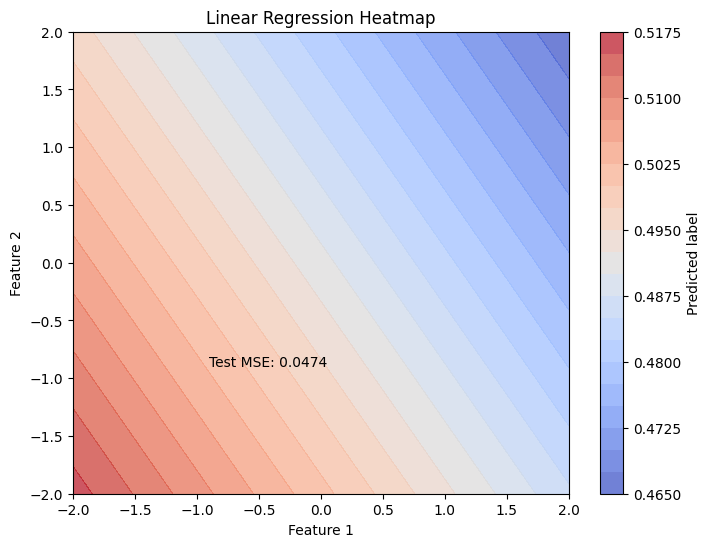

In [38]:
model = LinearRegression()
model.fit(X_train, y_train)

# Create a grid over [0,1]^2 for visualization
grid_size = 100
axes = 2
xx, yy = np.meshgrid(np.linspace(-axes, axes, grid_size), np.linspace(-axes, axes, grid_size))
grid_points = torch.tensor(np.c_[xx.ravel(), yy.ravel()], dtype=torch.float64)
probabilities = model.predict(grid_points).reshape(grid_size, grid_size)

# Plot the heatmap using contourf
plt.figure(figsize=(8, 6))
plt.contourf(xx, yy, probabilities, levels=20, cmap="coolwarm", alpha=0.75)

# Scatter plot of data points
# plt.scatter(X[y == 0, 0], X[y == 0, 1], color="blue", label="Class 0", alpha=0.6, edgecolor='k')
# plt.scatter(X[y == 1, 0], X[y == 1, 1], color="red", label="Class 1", alpha=0.6, edgecolor='k')


plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.title("Linear Regression Heatmap")
y_hat = torch.tensor(model.predict(X_test), dtype=torch.float64)
plt.text(-0.9,-0.9,f'Test MSE: {torch.mean((y_hat-y_test)**2):.4f}')
plt.colorbar(label="Predicted label")
plt.show()

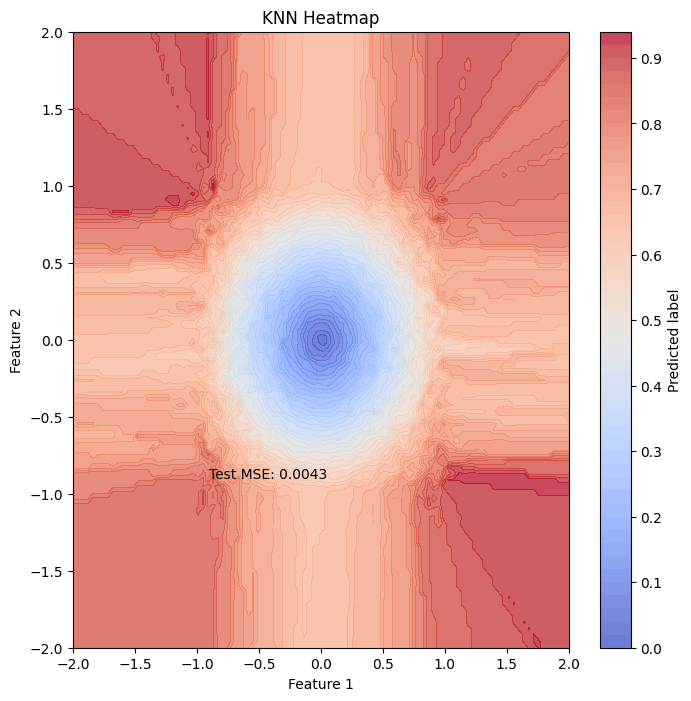

In [39]:
model = KNeighborsRegressor()
model.fit(X_train,y_train)
probabilities = model.predict(grid_points).reshape(grid_size, grid_size)

# Plot the heatmap using contourf
plt.figure(figsize=(8, 8))
plt.contourf(xx, yy, probabilities, levels=50, cmap="coolwarm", alpha=0.75)

# Scatter plot of data points
# plt.scatter(X[y == 0, 0], X[y == 0, 1], color="blue", label="Class 0", alpha=0.6, edgecolor='k')
# plt.scatter(X[y == 1, 0], X[y == 1, 1], color="red", label="Class 1", alpha=0.6, edgecolor='k')

plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.title("KNN Heatmap")
y_hat = torch.tensor(model.predict(X_test), dtype=torch.float64)
plt.text(-0.9,-0.9,f'Test MSE: {torch.mean((y_hat-y_test)**2):.4f}')
plt.colorbar(label="Predicted label")
plt.show()

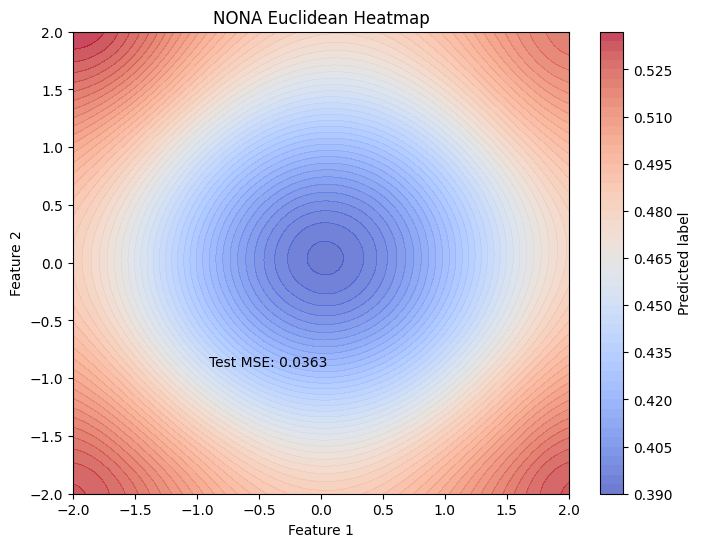

In [43]:
model = nona.NONA(batch_norm=2)
probabilities = model(grid_points, X_train, y_train).reshape(grid_size, grid_size).detach()

# Plot the heatmap using contourf
plt.figure(figsize=(8, 6))
plt.contourf(xx, yy, probabilities, levels=50, cmap="coolwarm", alpha=0.75)

# Scatter plot of data points
# plt.scatter(X[y == 0, 0], X[y == 0, 1], color="blue", label="Class 0", alpha=0.6, edgecolor='k')
# plt.scatter(X[y == 1, 0], X[y == 1, 1], color="red", label="Class 1", alpha=0.6, edgecolor='k')

plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.title("NONA Euclidean Heatmap")
y_hat = model(X_test, X_train, y_train)
plt.text(-0.9,-0.9,f'Test MSE: {torch.mean((y_hat-y_test)**2):.4f}')
plt.colorbar(label="Predicted label")
plt.show()

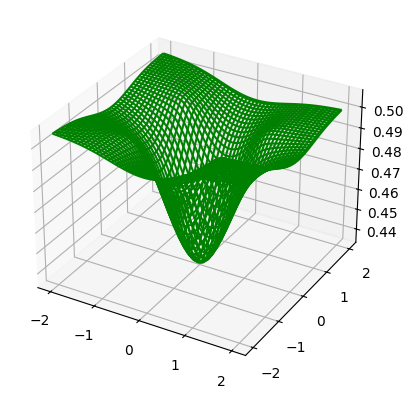

In [27]:
x_grid = torch.linspace(-2, 2, 100).to(torch.float64)
y_grid = torch.linspace(-2, 2, 100).to(torch.float64)

grid = torch.cartesian_prod(x_grid, y_grid)

Z = model(grid, X_train, y_train).reshape(100,100).detach()

X_grid, Y_grid = np.meshgrid(x_grid, y_grid)

fig = plt.figure()
ax = plt.axes(projection ='3d')
ax.plot_wireframe(X_grid, Y_grid, Z, color ='green')

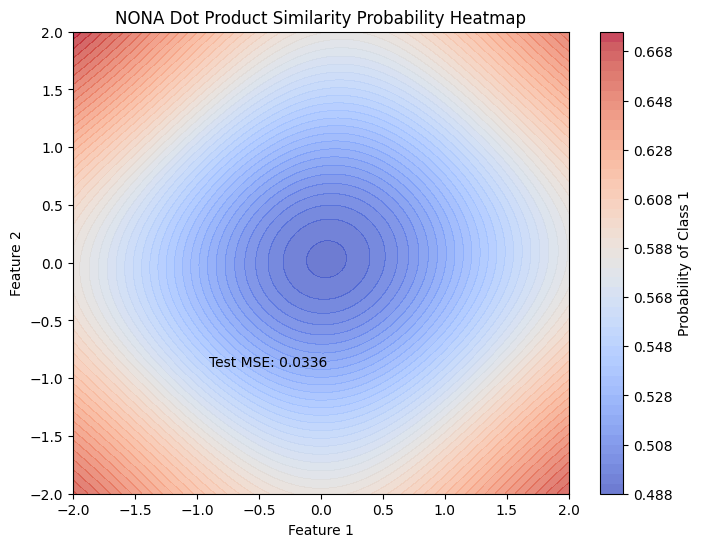

In [44]:
model = nona.NONA(batch_norm=2, similarity='dot')
probabilities = model(grid_points, X_train, y_train).reshape(grid_size, grid_size).detach()

# Plot the heatmap using contourf
plt.figure(figsize=(8, 6))
plt.contourf(xx, yy, probabilities, levels=50, cmap="coolwarm", alpha=0.75)

# Scatter plot of data points
# plt.scatter(X[y == 0, 0], X[y == 0, 1], color="blue", label="Class 0", alpha=0.6, edgecolor='k')
# plt.scatter(X[y == 1, 0], X[y == 1, 1], color="red", label="Class 1", alpha=0.6, edgecolor='k')

plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.title("NONA Dot Product Similarity Probability Heatmap")
y_hat = model(X_test, X_train, y_train)
plt.text(-0.9,-0.9,f'Test MSE: {torch.mean((y_hat-y_test)**2):.4f}')
plt.colorbar(label="Probability of Class 1")
plt.show()

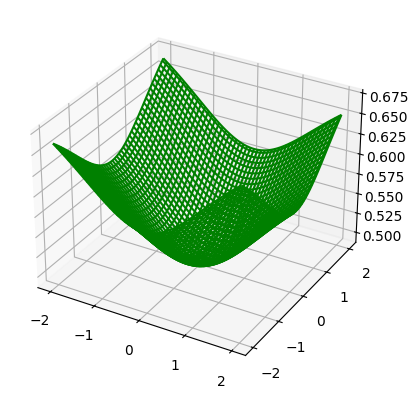

In [45]:
x_grid = torch.linspace(-2, 2, 100).to(torch.float64)
y_grid = torch.linspace(-2, 2, 100).to(torch.float64)

grid = torch.cartesian_prod(x_grid, y_grid)

Z = model(grid, X_train, y_train).reshape(100,100).detach()

X_grid, Y_grid = np.meshgrid(x_grid, y_grid)

fig = plt.figure()
ax = plt.axes(projection ='3d')
ax.plot_wireframe(X_grid, Y_grid, Z, color ='green')

Epoch 0: Loss = 0.0032, k = 0.054, s = 0.106
Epoch 10: Loss = 0.0020, k = 0.059, s = 0.094
Epoch 20: Loss = 0.0019, k = 0.056, s = 0.095
Epoch 30: Loss = 0.0019, k = 0.051, s = 0.097
Epoch 40: Loss = 0.0019, k = 0.048, s = 0.092
Epoch 50: Loss = 0.0018, k = 0.045, s = 0.088
Epoch 60: Loss = 0.0018, k = 0.038, s = 0.089
Epoch 70: Loss = 0.0018, k = 0.034, s = 0.083
Epoch 80: Loss = 0.0018, k = 0.033, s = 0.072
Epoch 90: Loss = 0.0017, k = 0.034, s = 0.059
Epoch 100: Loss = 0.0017, k = 0.034, s = 0.054
Epoch 110: Loss = 0.0017, k = 0.033, s = 0.051
Epoch 120: Loss = 0.0017, k = 0.033, s = 0.050
Epoch 130: Loss = 0.0017, k = 0.029, s = 0.056
Epoch 140: Loss = 0.0016, k = 0.030, s = 0.049
Epoch 150: Loss = 0.0016, k = 0.031, s = 0.039
Epoch 160: Loss = 0.0016, k = 0.033, s = 0.031
Epoch 170: Loss = 0.0017, k = 0.033, s = 0.030
Epoch 180: Loss = 0.0016, k = 0.032, s = 0.036
Epoch 190: Loss = 0.0015, k = 0.031, s = 0.033
Train Loss = 0.0014, final k = 0.033, final s = 0.023


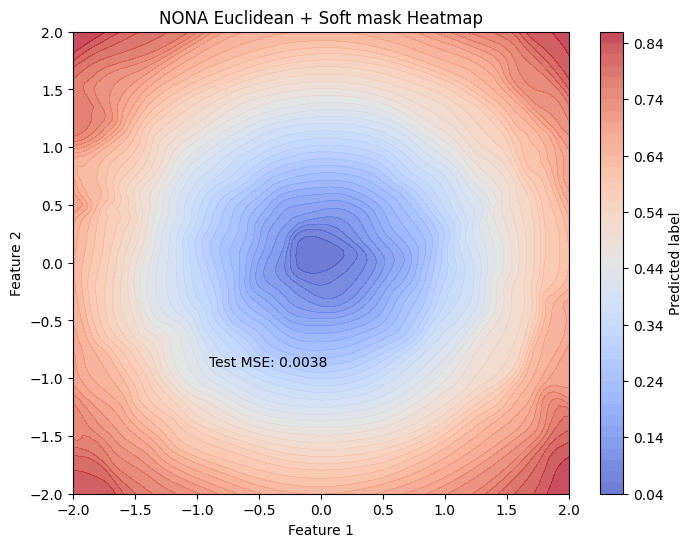

In [46]:
reload(masks)
reload(nona)

hl_sizes = [100,100,100,100]
mask = masks.SoftKNNMask()
model = nona.NONA_NN(predictor='nona', similarity='euclidean', input_size=2, hl_sizes=hl_sizes, mask=mask)

optimizer = optim.Adam(model.parameters(), lr=0.001)

dataset = TensorDataset(X_train, y_train)
dataloader = DataLoader(dataset, batch_size=200)
for epoch in range(200):
    model.train()
    old_train_loss = 50
    new_train_loss = 0.0
    for x,y in dataloader:
        y_pred = model(x,x,y).squeeze()

        loss = nn.MSELoss()(y_pred, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        new_train_loss += loss.item()

    new_train_loss /= len(dataloader)

    if epoch % 10 == 0:
        report = f"Epoch {epoch}: Loss = {new_train_loss:.4f}, "
        if model.predictor=='nona' and model.mask:
            report+= f'k = {model.mask.k.item():.3f}, s = {model.mask.s.item():.3f}'
        print(report)
        if old_train_loss < new_train_loss:
            break
        old_train_loss = new_train_loss

final_report = f"Train Loss = {loss.item():.4f}"
if model.predictor == 'nona' and model.mask:
    final_report += f", final k = {model.output_layer.mask.k.item():.3f}, final s = {model.output_layer.mask.s.item():.3f}"
print(final_report)

probabilities = model(grid_points, X_train, y_train).reshape(grid_size, grid_size).detach()

# Plot the heatmap using contourf
plt.figure(figsize=(8, 6))
plt.contourf(xx, yy, probabilities, levels=50, cmap="coolwarm", alpha=0.75)

# Scatter plot of data points
# plt.scatter(X[y == 0, 0], X[y == 0, 1], color="blue", label="Class 0", alpha=0.6, edgecolor='k')
# plt.scatter(X[y == 1, 0], X[y == 1, 1], color="red", label="Class 1", alpha=0.6, edgecolor='k')

plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.title("NONA Euclidean + Soft mask Heatmap")
y_hat = model(X_test, X_train, y_train).squeeze()
# if model.predictor == 'dense':
#     y_hat = torch.sigmoid(y_hat)
plt.text(-0.9,-0.9,f'Test MSE: {torch.mean((y_hat-y_test)**2):.4f}')
plt.colorbar(label="Predicted label")
plt.show()

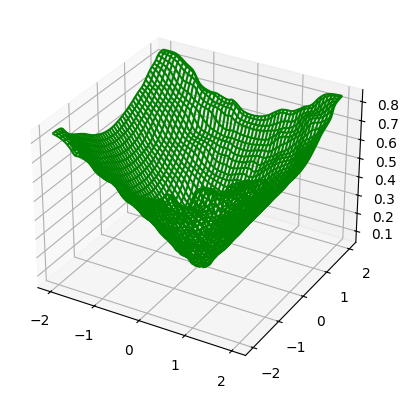

In [47]:
x_grid = torch.linspace(-2, 2, 100).to(torch.float64)
y_grid = torch.linspace(-2, 2, 100).to(torch.float64)

grid = torch.cartesian_prod(x_grid, y_grid)

Z = model(grid, X_train, y_train).reshape(100,100).detach()

X_grid, Y_grid = np.meshgrid(x_grid, y_grid)

fig = plt.figure()
ax = plt.axes(projection ='3d')
ax.plot_wireframe(X_grid, Y_grid, Z, color ='green')

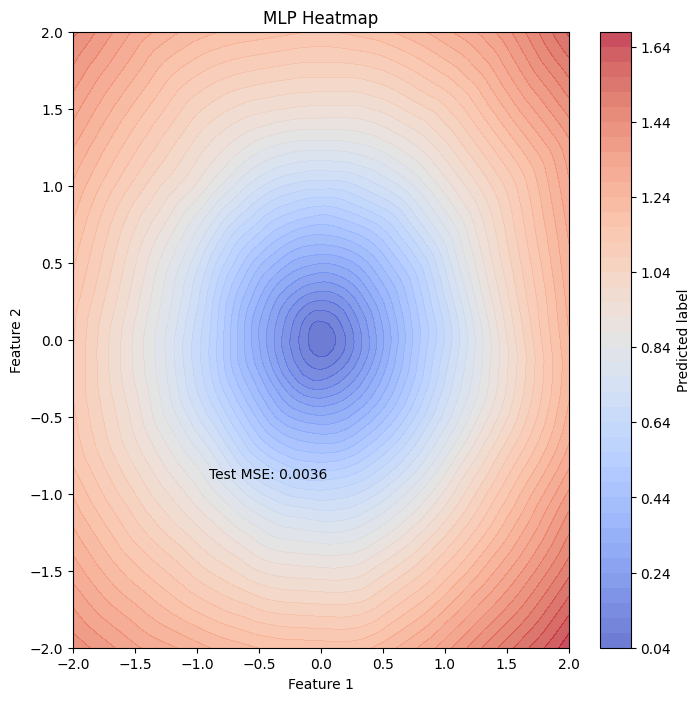

In [48]:
model = MLPRegressor(hidden_layer_sizes=hl_sizes)
model.fit(X_train,y_train)
probabilities = model.predict(grid_points).reshape(grid_size, grid_size)

# Plot the heatmap using contourf
plt.figure(figsize=(8, 8))
plt.contourf(xx, yy, probabilities, levels=50, cmap="coolwarm", alpha=0.75)

# Scatter plot of data points
# plt.scatter(X[y == 0, 0], X[y == 0, 1], color="blue", label="Class 0", alpha=0.6, edgecolor='k')
# plt.scatter(X[y == 1, 0], X[y == 1, 1], color="red", label="Class 1", alpha=0.6, edgecolor='k')

plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.title("MLP Heatmap")
y_hat = torch.tensor(model.predict(X_test), dtype=torch.float64)
plt.text(-0.9,-0.9,f'Test MSE: {torch.mean((y_hat-y_test)**2):.4f}')
plt.colorbar(label="Predicted label")
plt.show()

The MLP simply has to learn the transformation (x_1,x_2) -> sqrt(x_1^2+x_2^2) before linear regression. The homoscedasticity of the data is beneficial